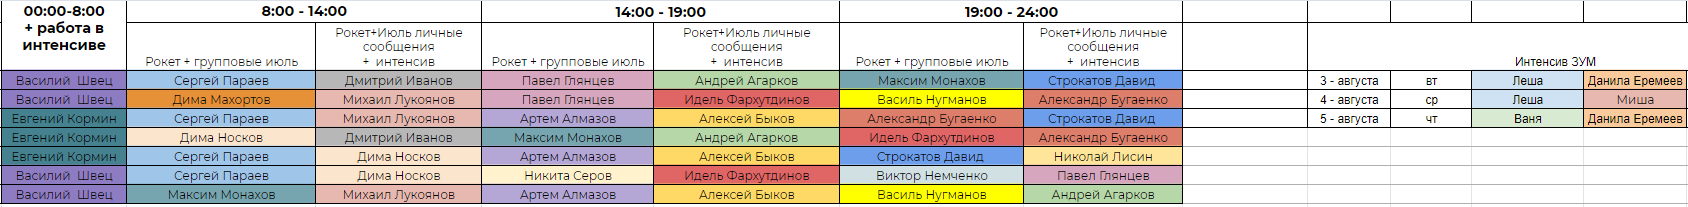

#Задача планирование

Обучение с подкреплением используется не только чтобы играть в игры или управлять роботами - эта стратегия также часто используется для решения многих других задач, в том числе и планирование.

Планирование - это задача составление расписания. Это может быть расписание, например, работы конвеера (нужно решить, какая машина где будет находиться и что делать в заданное время, чтобы оптимизировать процесс). 

В этом примере будет рассматривается гипотетическая задача: составление расписания работы соотрудников в компании. Для примера используется график работы кураторов УИИ. 

У каждого куратора есть различные характеристики, которые решают когда они могут или не могут выходить на работу. Именно есть:

* Выходные дни
* Отпуска
* Предпочитаемые часы работы
* Разные временные пояса
* Назначеные встречи/прочие дела
* Разные ставки работы (пол-ставки/полная ставка)

Причём, все эти характеристики могут меняться из недели в неделю, по скольку у человека меняется расписание. Нужно составить расписание, которое учитывает всё это - но желательно это делать не вручную, а через алгоритм искусственного интеллекта.

*Примечание: этот алгоритм только является демонстратором возможности составление расписания, и не используется на практике.*

Импортируем все нужные модули и библиотеки, подключаемся к диску.

In [ ]:
import tensorflow as tf       #Библиотека тензорфлоу
import numpy as np            #Библиотека numpy
import random                 #Импортируем модуль для генерации рандомных значений
import pickle                 #Модуль для сохранения результатов в файл
import cv2                    #Модуль для работы с картинками и видео (нужно для предобработки данных и записи результата)
import random

#Импортируем тип данных deque из встроенного модуля питона
from collections import deque   #deque - это список где автоматический удаляются старые значения при добовлении новых, чтобы не было переполнение памяти.
import matplotlib.pyplot as plt #Импортируем модуль pyplot из бибиотеки matplotlib

from tensorflow.keras.models import load_model, Model, Sequential #Импортируем функции для создания и загрузки модели из тензорфлоу
from tensorflow.keras.layers import *                             #Импортируем все слои из кераса
from tensorflow.keras.optimizers import RMSprop                   #Импортируем оптимизатор RMSprop
from tensorflow.keras import backend as K                         #Импортируем модуль для бэкэнда кераса
from tensorflow.keras.utils import to_categorical                 #Импортируем функцию для удобного onehot энкодинга

import pickle                         #Модуль для сохранения результатов в файл
from google.colab import output       #Импортируем модуль который помогает очищать вывод из ячейки колаба.

In [ ]:
from google.colab import drive   #Монтируем гугл диск
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Создание среды

Дальше создается класс, который инициализирует среду. 

В данном случае, среда - это "пустой" график который нужно заполнить дежурными работниками. Работа происходит семь дней в неделю, и на протяжении дня есть четыре смены. На протяжении всего дня, семь людей должны выйти на работу, кроме дней с интенсивами, когда выходит девять людей (интенсивы происходят ровно три раза в неделю).

Заполнение графика можно интерпритировать как "игру", за которую назначаются награды. Логика этой псевдо-игры, а также код для назначений наград, описывается ниже.

In [ ]:
#Объявляем класс для создания среды
 #Функция инициализации принимает на вход алгоритм (его описания будет позже), и количество минимальных и максимальных работников, на который предназначен алгоритм
class schedule_environment:
  def __init__(self, algorithm, min_curators = 28, max_curators = 32):
    self.algorithm = algorithm                                        #Записываем алгоритм в объект класса

    self.min_curators = min_curators                                  #Записываем количество минимальных кураторов в объект класса
    self.max_curators = max_curators                                  #Записываем количество максимальных кураторов в объект класса
    self.num_curators = np.random.randint(min_curators, max_curators) #Записываем количество максимальных кураторов в объект класса

    self.num_rows = 7         #В таблице есть 7 рядов, т.к. УИИ работает 7 дней в неделю.
    self.num_cols = 9         #В таблице есть 9 столбцов, т.к. кураторы выходят на дежурство максимум 9 раз в день.

    self.duty_timetable = np.ones((self.num_rows, self.num_cols)) * -2   #Инициализиуем все значения в таблице как -2 (-2 значит незаполнено)

  #Функция для создания расписания куратора - куратор отмечает, когда он хочет работать, и когда не может. 
  #На текущий момент, это расписание создается полностью рандомным образом, без учёта временного пояса или количество востребованных кураторов на время дня.
  def get_random_schedule(self, days_good, times_bad): #На вход функции принимаются параметры: смены когда куратор предпочетает дежурить, и смены когда не может
    time_schedule = np.zeros((7, 4))  #Инициализиуруем расписания куратора нулями (7 дней в неделю, 4 смены в день). 0 в расписании значит "мне без разницы - я могу в это время дежурить".
    previously_accessed_indices = []  #Инициализируем пустой список, куда будем добавлять индексы ячеек описывающие когда куратор предпочитает или не может дежурить.
    i = 0      #i это счетчик, с помощью которого мы используем while цикл
    while i < days_good:          #В while цикле рандомным образом выбераем смены, когда куратор предпочетает дежурить.
      x_index, y_index = np.random.randint(0, time_schedule.shape[0]), np.random.randint(0, time_schedule.shape[1]) #Генерим рандомный индекс из таблицы
      if (x_index, y_index) not in previously_accessed_indices:    #Если смена не помечена, мы с ней продолжаем работать (иначе, если её индекс уже был выбран, цикл сгенерит новый индекс)
        previously_accessed_indices.append((x_index, y_index))     #Добавляем индекс смены в таблицу 
        time_schedule[x_index, y_index] = 1                        #Записываем значения индекса в 1 (что значит, куратор предпочитает дежурить в это время)
        i += 1 #Увеличиваем счетчик i на единицу

    i = 0      #i это счетчик, с помощью которого мы используем while цикл
    while i < times_bad:          #В while цикле рандомным образом выбераем смены, когда куратор не может дежурить.
      x_index, y_index = np.random.randint(0, time_schedule.shape[0]), np.random.randint(0, time_schedule.shape[1]) #Генерим рандомный индекс из таблицы
      if (x_index, y_index) not in previously_accessed_indices:    #Если смена непомечена, мы с ней продолжаем работать (иначе, если её индекс уже был выбран, цикл сгенерит новый индекс)
        previously_accessed_indices.append((x_index, y_index))     #Добавляем индекс смены в таблицу 
        time_schedule[x_index, y_index] = -1                       #Записываем значения индекса в -1 (что значит, куратор не может дежурить в это время)
        i += 1 #Увеличиваем счетчик i на единицу                                                                                  

    shift_schedule = np.zeros((self.num_rows, self.num_cols)) #Создаем новую таблицу - в этой таблице будут 9 смен, которые пересикаются по времени (9 временных промежутков)                                        
    indices_map = {0:0, 1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3} #Создаем словарь с индексами новой и старой таблицы (0 - это ночное время когда дежурит один куратор, 1 - это утро, когда дежурят два куратора, 2 - это обед, когда дежурят два куратора, 3 - это вечер, когда дежурят четыре куратора, 2 из которых на интенсивах)
    for i, j in indices_map.items():             #Итерируем по словарю, чтобы записать новые значения в новую таблицу
      shift_schedule[:, i] = time_schedule[:, j] #Записываем новые значения в таблицу графика куратора

    return shift_schedule  #Возвращаем график, который отображает на каких сменах куратор может или не может дежурить

  #Следующая функция рандомным образом генерит данные о кураторе: его временной пояс, график когда он предпочитает/не может дежурить, и если он работает на полную ставку или на пол ставки
  def create_curator(self):
    traits_list = []               #Создаем пустой список, где будет содержаться вся описательная информация о кураторе

    preferred_time = preferred_time = random.randint(1, 24)  #Временной пояс куратора рандомно генериться от 1 до 24
    traits_list.append(preferred_time)                       #Записываем временной пояс куратора в список характеристик

    work_type = np.random.choice(['пол ставки', 'полная ставка'], p = (0.1, 0.9)) #С 10% вероятностью куратор будет полу-ставочником, с 90% вероятностью будет работать на полную ставку
    traits_list.append(0.5 if work_type == 'пол ставки' else 1) #Заменяем строку на 0.5 (значит пол ставки) или 1 (значит полная ставка)
    
    if work_type == 'полная ставка':   #Кураторы, которые работают на полную ставку должны быть готовы выходить на дежурство минимум 3 раза в неделю, и не могут быть заняты больше чем 5 раз в неделю
      num_good_days = random.randint(3, self.num_rows)     #Куратор будет готов дежурить от 3 до 7 раз в неделю
      num_bad_times = random.randint(0, self.num_rows - 2) #Куратор будет занят от 0 до 5 раз в неделю
    else:    #Кураторы, которые работают на пол-ставки должны быть готовы выходить на дежурство минимум 1 раз в неделю, и не могут быть заняты больше чем 7 раз в неделю
      num_good_days = random.randint(1, self.num_rows)     #Куратор будет готов дежурить от 1 до 7 раз в неделю
      num_bad_times = random.randint(0, self.num_rows)     #Куратор будет занят от 0 до 7 раз в неделю

    curator_timetable = self.get_random_schedule(num_good_days, num_bad_times) #Используя ранее объявленную функцию, генерим график, который описывает когда куратор может или не может дежурить
    traits_list.append(curator_timetable) #Добавляем график в список данных о кураторе

    return np.array(traits_list)   #Превращаем список в массив и возвращаем
  
  #Следующая функция генерит информацию для всех кураторов, которые работают в предприятии (итоговые данные можно рассматривать как среду)
  #Данные будут храниться в нескольких многомерных массивов, где разные каналы массива будут содержать информацию для разных кураторов
  def get_curator_stats(self): #Данные для кураторов инициализируются как -2 потому что массив "резервирует" места для всех кураторов - даже если кто-то на отпуске/ушёл/есть свободная вакансия. Идея в этом - чтобы нейронная сеть работала при разном количестве работников,но не ставила на дежурства людей, которых нету. 
    self.num_curators = random.randint(self.min_curators, self.max_curators)           #Рандомно инициализируем количество кураторов, которые могут работать     
    self.timezone_stats = np.ones((1, self.max_curators)).astype(np.float32) * -2
    self.employment_stats = np.ones((1, self.max_curators)).astype(np.float32) * -2    #Инициализируем массив, который содержит информацию о виде работы куратора (пол. ставки или полная ставка) как -2
    self.schedule_stats = np.ones((1, self.num_rows, self.num_cols, self.max_curators)).astype(np.float32) * -2 #Инициализиуем массив с предпочитаемым временем работы кураторов как -2
    curator_stats = [self.create_curator() for i in range(self.num_curators)] #Генерим данные для всех кураторов используя выше созданную функцию внутри list comprehension

    for i in range(self.num_curators):                       #В цикле переписываем данные из выше созданного списка в numpy массивы
      self.timezone_stats[:, i] = curator_stats[i][0]        #Перезаписываем данные о временном поясе из списка в numpy массив
      self.employment_stats[:, i] = curator_stats[i][1]      #Перезаписываем данные о виде работы из списка в numpy массив
      self.schedule_stats[:, :, :, i] = curator_stats[i][2]  #Перезаписываем данные о графики предпочитаемого времени работы из списка в numpy массив
    
    self.available_manpower = 0.5 * self.employment_stats[self.employment_stats == 0.5].size + self.employment_stats[self.employment_stats == 1].size #Считаем "рабочую силу" личного состава (пол-ставочник считается как половину работника, обычный работник считается как 1 работник). Это используется позже.

  #Создаем функцию, которая будет возвращать награды за различные действия. Награда состоит из трёх компонентов, известны как альфа-метрика, бета-метрика, и дельта-метрика.
  #Альфа, бета, и дельта метрики - произвольные названия. Они созданы чтобы отслеживать работу нейронной сети. Награда является суммой альфа, бета, и дельта метрик.
  #Данная функция вызывается после каждого действия (когда куратор ставиться на дежуство в временном промежутке), что значит - награды непрерывные.
  def get_reward(self, i, j):
    curator_index = int(self.duty_timetable[i, j])   #Индекс куратора - это его номер (от 0 до max_curator)
    reward = 0                                       #Награда инициализируется нулем

    #Метрика альфа - награда за расписание (положительная если алгоритм ставит кураторов на дежурство в удобное для них время, отрициательное если ставит когда они не могут работать).
    alpha_metric = self.get_schedule_reward(self.schedule_stats[0, i, j, curator_index]) #Считаем метрику альфа
    reward += alpha_metric                       #Добваляем метрику альфа в награду
    self.alpha_metric_batch += alpha_metric      #Увеличиваем значение метрики за эпизод (self.alpha_metric_batch объявляется в коде ниже)

    #Метрика бета - награда за временной промежуток (положительная если алгоритм ставит кураторов на дежурство 'днем', иначе отрициательная)
    beta_metric = self.get_timezone_reward(self.timezone_stats[0, curator_index], j) #Считаем метрику бета
    reward += beta_metric                        #Добваляем метрику бета в награду
    self.beta_metric_batch += beta_metric        #Увеличиваем значение метрики за эпизод (self.beta_metric_batch объявляется в коде ниже)

    #Метрика дельта всегда будет отрициательной. Она отвечает за количество "косяков" который делает алгоритм (если ставит одного куратора на дежурство слишком часто, больше чем 1 раз за день, или если данный куратор на отпуске.)
    delta_metric = self.get_times_used_reward(curator_index, i, j) #Считаем метрику дельта (примечание: из-за функции, с которой она задается, эта метрика будет ниже 0 даже если всё сделано отлично, но она будет ещё ниже если есть много косяков)
    reward += delta_metric                       #Добваляем метрику дельта в награду
    self.delta_metric_batch += delta_metric      #Увеличиваем значение метрики за эпизод (self.delta_metric_batch объявляется в коде ниже)
    
    return reward         #Возвращаем награду, которая является суммой: alpha_metric + beta_metric + delta_metric

  #Функция для извлечения награды по расписанию (это метрика альфа)
  def get_schedule_reward(self, element): #функция принимает на вход элемент ячейку из расписания куратора (либо 1 - я хочу в это время работать, либо 0 - мне без разницы, либо -1 - я не могу в это время работать).
    if element == 1:   #Если элемент таблицы равен 1, это значит алгоритм поставил куратора работать в удобное ему время.
      reward = 1       #За это назначается награда +1
    elif element == -1:   #Если элемент таблицы равен -1, это значит алгоритм поставил куратора работать когда он не может, или ему не удобно работать в это время.
      reward = -2         #За это назначается награда -1
    else:          #Иначе, элемент талбицы равен 0, что значит куратору без разницы работать в это время.
      reward = 0   #За это даётся нулевая награда.
    return reward   #Возвращаем награду.

  #Функция для извлечения награды по временному поясу (это метрика бета)
  def get_timezone_reward(self, element, timeslot): #Функция принимает на вход время в которое куратору удобно дежурить, и ячейку таблицы которая отвечает за час дежурства.
    if timeslot < 0:    #Если значение timeslot меньше 0, это значит куратор отсутствует - возвращаем нулевую награду (другая функция в таком случае даст отрициательную награду)
      return 0
    if timeslot == 0: local_time = 0         #Если значения timeslot равно 0, он начнет работать в 0:00 по МСК (ночью)
    elif timeslot in [1, 2]: local_time = 8  #Если значения timeslot равно 1 или 2, он начнет работать в 8:00 по МСК (утро)
    elif timeslot in [3, 4]: local_time = 14 #Если значения timeslot равно 3 или 4, он начнет работать в 14:00 по МСК (день)
    else: timeslot = 19                      #Иначе, это вечернее дежурство которое начинается в 19:00 по МСК (вечер)

    reward = 0.15 + -0.002 * min(element - timeslot, element - (24 - timeslot))**2 #Награда назначается следующей функцией - если удобное время которое обозначил куратор близко к времени, когда назначил алгоритм, награда положительная. Иначе, она отрициательная.
    return np.clip(reward, -0.1, 0.1)   #Сжимаем награду от -0.1 до +0.1. Величина этой награды маленькая, т.к. временной пояс может не соответстовать тому времени, когда куратор говорит ему удобно дежурить (оба параметра задаютя рандомно) - в таком случае сеть должна отдавать приоритет времени, который обозначает куратор.

  #Функция для извлечения награды по сильным косякам (это метрика дельта, и она всегда отрициательная)
  def get_times_used_reward(self, curator_index, i, j):    #Функция принимает на вход номер куратора (от 0 до max_curators) а также индексы ячейки таблицы графика (i, j)
    reward = 0
    curator_type = self.employment_stats[0, curator_index] #Узнаем, на какую ставку работает куратор (пол-ставки или полная ставка), или в принципе не работает.
    if curator_type < 0:                 #Если значения куратора меньше 0, это значит что куратора нет в составе.
      return -2                          #В таком случае, возвращаем отрициательную награду -2

    curator = self.duty_timetable[i, j]  #Извлекаем индекс куратора из таблицы расписания (от 0 до max_curators)
    num_times_allowed = curator_type * (self.duty_timetable.size - 8) / self.available_manpower #Количество раз, которое позволено куратору быть на дежурстве (считается чтобы рабочая нагрузка распределялась равномерно, и чтобы работники на пол-ставку работали в 2 раза меньше, чем на полную ставку).

    times_on_duty = (self.duty_timetable == curator).sum() #Считаем, сколько раз куратор уже был поставлен на дежурство
    if (self.duty_timetable[i, :] == curator).sum() > 1:   #Если куратор был поставлен на дежурство больше чем один раз в день:
      reward = -2 * (self.duty_timetable[i, :] == curator).sum()  #назначаем большую отрициательную наргаду, -2
      return reward

    elif times_on_duty > num_times_allowed:                       #Если куратор уже поставлен на дежурство больше раз, чем он должен работать
      reward = -0.2 * float((times_on_duty - num_times_allowed))  #Задается отрициательная наргада, чем больше куратор уже дежурит тем больше отрициательная величина награды (важно - по скольку times_on_duty не целое число, это всегда приведёт к хотя-бы небольшой отрициательной награде).
    reward += 1
    return reward    #Возвращаем подсчитанную награду

  #Создаем функция, в котором алгоритм будет создавать график работы на неделю. Это можно рассматривать как аналог 'игрового цикла'.
  #На вход принимаем две переменные: train_mode отвечает если алгоритм обучается или используется для теста, тем временем как episodes_in_batch отвечает за количество эпизодов которые пройдут до того как обучается алгоритм.
  #В одном эпизоде всего 55 действий, что довольно мало в качестве размера пакета для обучения. По этому, алгоритм будет 'играть' много эпизодов и затем совершать одну итерацию обучения.
  def create_schedule(self, train_mode = True, episodes_in_batch = 50):
    timezones = []         #Список временных поясов кураторов - является составной частью состояния
    employments = []       #Список вида работы кураторов (полу-ставка или полная ставка) - является составной частью состояния
    schedules = []         #Список расписаний кураторов (трёх-мерная матрица которая содержит двумерный график для каждого куратора) - является составной частью состояния
    timetables = []
    episode_actions = []   #Список действий за эпизод (действие - назначения работника на дежурство)
    all_rewards = []       #Список наград котороые получены за каждое действие

    self.alpha_metric_batch = 0  #Инициализируем значение метрики альфа за пакет эпизодов как 0
    self.beta_metric_batch = 0   #Инициализируем значение метрики бета за пакет эпизодов как 0
    self.delta_metric_batch = 0  #Инициализируем значение метрики дельта за пакет эпизодов как 0
    
    for episode in range(episodes_in_batch):   #В цикле обнуляем и создаем таблицу много раз.
      episode_rewards = []                     #Инициализируем награды за эпизод пустым списком.
      self.duty_timetable = np.ones((self.num_rows, self.num_cols)) * -2  #Инициализиуем график работы всех кураторов значениями -2 (если -2 не будет позже заполнен, это обозначает что куратор отсутствует).
      self.get_curator_stats()         #Вызываем функцию которая генерит рандомное количество кураторов, их временные пояса, виды работы, и предпочитаемые время работы.
      for i in range(self.num_rows):   #Циклом итерируем через ряды (дни) в графике.
        for j in range(self.num_cols): #Циклом итерируем через столбцы (окна дежурств) в графике.
          if not (j >= 3 and i >= 7): #Убераем окна из дней когда нету интенсивов
            graph = np.append(self.duty_timetable.copy().reshape(1, self.num_rows, self.num_cols, 1), self.schedule_stats.copy(), axis = 3) #Создаем график, который будет подаваться в нейронную сеть. Этот график - трёхмерный тензор который получается при склеивании графика дежурств (duty_timetable) с графиками удобных и неприемлемых времен всех кураторов.
            
            onehot_timetable = tf.keras.utils.to_categorical([self.duty_timetable], self.max_curators + 2)

            state = (self.timezone_stats, self.employment_stats, self.schedule_stats, onehot_timetable) #Полное состояние - это кортеж из выше-созданного графика, а также списки временных поясов и виды занятости всех работников.
            if train_mode: #Если алгоритм обучается:
              action = self.algorithm.get_train_action(state) #Извлекаем действие (какого куратора поставить на дежурство в ячейку (i, j) по заданному состоянию) используя рандомные вероятности.
            else:          #Иначе (алгоритм уже обучен и он используется при тесте):
              action = self.algorithm.get_test_action(state) #Извлекаем действие (какого куратора поставить на дежурство в ячейку (i, j) по заданному состоянию) выбирая классификацию с максимальной вероятности.

            self.duty_timetable[i, j] = action #Записываем действие (то есть, выбранного куратора) в график всех дежурств.
            reward = self.get_reward(i, j)     #Используем ранее заданную функцию чтобы извлечь награду за действие.
            
            timezones.append(self.timezone_stats[0])     #Записываем массив временных поясов кураторов в список (это часть состояния).
            employments.append(self.employment_stats[0]) #Записываем массив ставок кураторов в список (это часть состояния).
            schedules.append(self.schedule_stats[0])     #Записываем частично-заполненный график дежурств и графики готовности на работу всех кураторов в список (это часть состояния).
            timetables.append(onehot_timetable[0])
            episode_actions.append([action])   #Записываем действие в список.
            episode_rewards.append(reward)     #Записываем награду в список.

      episode_rewards = self.algorithm.preprocess_rewards(episode_rewards) #Предобрабатываем награды за эпизод (нужно предобрабатывать награды за эпизод отдельно чтобы слгоритм не воспринимал разные эпизоды как часть одной последовательности при обработки наград).
      all_rewards += episode_rewards #all_rewards и episode_rewards оба списки, в этой строке кода мы конкатенируем списки.

    total_reward = np.array(all_rewards).sum() #Считаем сумму наград за все эпизоды в пакете (используется в качестве метрики)

    return timezones, employments, schedules, timetables, episode_actions, all_rewards, total_reward  #Возвращаем массивы состояний (timezones, employments, schedules, timetables), действий (episode_actions), наград (all_rewards), и сумму наград (total_reward)

##Создание алгоритма

Дальше создается самописный класс, который будет содержать нейронную сеть, её гиперпараметры, а также логику для инференса и обучения нейронной сети. Ранее созданный класс среды будет также содержаться внутри этого класса.

In [ ]:
#Создаем класс алгоритма. Класс принимает на вход значение Гамма, и параметр load_pretrained.
#Если load_pretrained = False, обучение происходит с нуля. Иначе, обучение продолжается с предидущего сохранения.
class REINFORCE:
  def __init__(self, gamma = 0.95, load_pretrained = False):
    self.environment = schedule_environment(self) #Записываем среду внутри объекта алгоритма. Подаем self в объект чтобы можно было обращаться к алгоритму в объекте среды.
    self.gamma = gamma               #Записываем значение гаммы в объект
    self.learning_rate = 1e-4        #Записываем размер шага обучения в объект
    self.model = self.create_model() #Создаем модель через функцию (которая объявляется внутри класса), записываем модель в объект
    self.rewards = []                #Создаем массив наград за все эпизоды (используется в качестве метрики)
    self.alpha_metrics = []          #Создаем массив альфа-метрик за все эпизоды (используется в качестве метрики)
    self.beta_metrics = []           #Создаем массив бета-метрик за все эпизоды (используется в качестве метрики)
    self.delta_metrics = []          #Создаем массив дельта-метрик за все эпизоды (используется в качестве метрики)

    self.save_directory = '/content/drive/My Drive/pretrained_networks/reinforce_schedule/' #Записываем директорию, куда будут сохраняться веса модели и массивы метрик

    if load_pretrained:   #Если продолжаем обучения:
      self.load_results() #Вызываем функцию которая сохраняет веса модели и записанные метрики за эпизоды

  #Объявляем функцию для предобработки наград (непрерывные награды). Эта функция принимает на вход список "сырых" наград, и возвращает обработанные награды.
  def preprocess_rewards(self, rewards): 
    processed_rewards = np.zeros_like(rewards).astype(np.float32) #Инициализируем новый массив нулями, куда будем записывать предобрадотанные награды
    running_add = 0 #Инициализируем значение скользящей суммы нулём
    for i in reversed(range(0, len(rewards))): #Проходимся черех массив наград в обратном порядке
      running_add = running_add * self.gamma + rewards[i] # sum * y (gamma) + reward (псевдо-уравнения бэллмена)
      processed_rewards[i] = running_add         #Устанавливаем значение награды в соответствии уравнения бэллмена
    return processed_rewards.flatten().tolist()  #Возвращаем одномерный список наград

  #Функция инференса, с помощью которой алгоритм сеть будет принимать решение рандомным образом, используя предсказанные вероятности нейросети.
  def get_train_action(self, state):
    probabilities = self.model.predict(state) #Нейронная сеть предсказывает вероятности принятия всех действий по состоянию.
    result = np.random.choice(np.arange(self.environment.max_curators), p = probabilities.flatten()) #Затем, алгоритм рандомно выбирает действия используя заданные вероятности.
    return result #Возвращаем выбранное действие.

  def get_test_action(self, state):
    probabilities = self.model.predict(state)
    return np.argmax(probabilities)

  #Функция создания нейронной сети - нейронная сеть имеет четыре входа (у состояния есть четыре составные части - временные пояса работников, рабочая ставка, предпочтенные время работы кураторов, и заполненный график работы всех кураторов).
  def create_model(self):
    preferred_time_branch = Input((self.environment.max_curators,)) #Ветка, которая принимает на вход временные пояса работников (часть состояния)
    worktype_branch = Input((self.environment.max_curators,))       #Ветка, которая принимает на вход вид работы соотрудников (часть состояния)
    schedules_branch = Input((self.environment.num_rows, self.environment.num_cols, self.environment.max_curators))     #Ветка, которая принимает на вход личные расписания соотрудников (часть состояния)
    timetable_branch = Input((self.environment.num_rows, self.environment.num_cols, self.environment.max_curators + 2)) #Ветка, которая принимает на вход график дежурств, который заполняется в эпизоде (часть состояния)

    x3 = Flatten()(schedules_branch) #Выравниваем массив графиков соотрудников, чтобы затем можно было конкатенировать с остальными ветками
    x4 = Flatten()(timetable_branch) #Выравниваем массив расписания за неделю, чтобы затем можно было конкатенировать с остальными ветками

    x = concatenate([preferred_time_branch, worktype_branch, x3, x4]) #Конкатенируем все четыре входные ветки в одну
    x = Dense(512, activation = 'elu')(x)                             #Добавляем один полносвязанный слой с активационной функции elu
    out = Dense(self.environment.max_curators, activation = 'softmax')(x) #Добавляем выходной слой с max_curators количеством нейронов (сетка может выбрать любого работника на дежурство)
    model = Model([preferred_time_branch, worktype_branch, schedules_branch, timetable_branch], out) #Создаем модель используя функциональный АПИ
    model.compile(optimizer = RMSprop(learning_rate = self.learning_rate), loss = 'sparse_categorical_crossentropy') #Компилируем модель, используем RMSprop в качестве оптимизатора и низкий шаг обучения
    return model   #Функция возвращает компилированную модель

  #Объявляем функцию для сохранения прогресса обучения. Функция сохраняет модель, а также ранее полученные метрики.
  def save_results(self):
    self.model.save(self.save_directory + 'neural_network.h5')    #Сохраняем модель в файл
    with open(self.save_directory + 'rewards_array', 'wb') as f:  #Открываем текстовый файл, куда будем записывать значения ранее полученных метрик
      pickle.dump([self.rewards, self.alpha_metrics, self.beta_metrics, self.delta_metrics], f) #Сохраняем метрики в файл.

  #Объявляем функцию для загрузки ранее сохраненной модели и значения метрик, чтобы можно было продолжать обучение.
  def load_results(self):
    self.model = load_model(self.save_directory + 'neural_network.h5') #Загружаем модель из директории, где она сохранена.
    with open(self.save_directory + 'rewards_array', 'rb') as f:       #Открываем текстовый файл, который содержит ранее сохраненные метрики.
      self.rewards, self.alpha_metrics, self.beta_metrics, self.delta_metrics = pickle.load(f) #Загружаем метрики в переменные чтобы можно было выводить график за всё обучение.

  #Дальше, создаем функцию для обучения алгоритма. Эта функция будет использовать ранее созданную функцию для проигрывания эпизода, которая содержиться внутри класса environment.
  #Функция принимает на вход количество эпизодов в одном пакете (эпохе) и количество эпох обучения. 
  #Очень важно чтобы количество эпох в эпизоде было достаточно большим, потому что иначе будет слишком маленький размер пакетов данных для стабильного обучение алгоритма.
  def train_algorithm(self, episodes_in_batch = 20, train_times = 1000):
    for i in range(train_times): #В цикле обучаемся нужное количество раз.
      timezones, employments, schedules, timetables, episode_actions, all_rewards, total_reward = self.environment.create_schedule(episodes_in_batch = episodes_in_batch) #Вызываем функцию проигрывания эпизода, и получаем состояния, действия, и награды из эпизода.
      #Дальше, записываем сумму наград и метрик за пакет эпизодов в списки. Это делается для отображения графиков.
      self.rewards.append(total_reward)                                  #Записываем сумму общих наград за пакет эпизодов в список.
      self.alpha_metrics.append(self.environment.alpha_metric_batch)     #Записываем сумму альфа-метрик за пакет эпизодов в список.
      self.beta_metrics.append(self.environment.beta_metric_batch)       #Записываем сумму бета-метрик за пакет эпизодов в список.
      self.delta_metrics.append(self.environment.delta_metric_batch)     #Записываем сумму дельта-метрик за пакет эпизодов в список.
      
      #Переводим все полученные данные в numpy массивы, устанавливаем тип данных float32
      timezones = np.array(timezones).astype(np.float32)               #Переводим список временных поясов в numpy массив с dtype float32
      employments = np.array(employments).astype(np.float32)           #Переводим список ставок в numpy массив с dtype float32
      schedules = np.array(schedules).astype(np.float32)               #Переводим список расписаний работников в numpy массив с datatype float32
      timetables = np.array(timetables).astype(np.float32)             #Переводим список заполненных графиков дежурств в numpy массив с datatype float32
      episode_actions = np.array(episode_actions).astype(np.float32)   #Переводим список действий (решений нейронной сети) в numpy массив с datatype float32
      all_rewards = np.array(all_rewards)

      #Обучаем нейронную сеть используя состояния, действия нейронной сети, и награды.
      self.model.train_on_batch([timezones, employments, schedules, timetables], episode_actions, sample_weight = all_rewards)

      if i % 10 == 0: #Раз в десять эпизодов, отображаем графики наград и сохраняем прогресс.
        show_rewards(self.rewards, self.alpha_metrics, self.beta_metrics, self.delta_metrics) #Используем функцию (которая объявлена чуть позже) чтобы отобразить график обучения.
        self.save_results()           #Сохраняем прогресс обучения.

Ниже написанный код содержит функцию для отображения графиков, которые содержат историю наград и метрик. Мы можем узнать как хорошо и как быстро обучается алгоритм, посмотрев на скользящее среднее от награды и метрик.

In [ ]:
#Создаем функцию для подсчета скользящих средних значений из массива.
def moving_average(data, width = 100): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))        #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])    #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return np.convolve(data, np.ones(width), 'valid') / width   #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

#Создаем функцию для отображения награды и метрик за пакеты эпизодов. Функция принимает на вход все метрики, которые требуется отобразить.
def show_rewards(episode_rewards, alpha_metrics, beta_metrics, delta_metrics):
  output.clear()   #Сначала, удаляем предидущий вывод (это делается, чтобы не было переполнение памяти огромным количеством графиков).
  fig, axes = plt.subplots(2, 2, figsize = (20, 10)) #Создаем большой размер полотна.
  axes[0,0].plot(episode_rewards, color = 'blue', linestyle = '--', label = 'Награда за итерацию (после обработки)')          #Выводим график наград за пакет эпизодов
  axes[0,0].plot(moving_average(episode_rewards), color = 'red', label = 'Скользящее среднее награды (после обработки)')      #Выводим скользящее среднее наград
  axes[0,0].axhline(y = 0, color='k', linestyle='-')                                                                          #Рисуем горизонтальную линию на y = 0 (чтобы понять какие награды выше/ниже нуля).
  axes[0,0].set_xlabel('Эпоха обучения')                                                                                      #Устанавливаем лейблы осей
  axes[0,0].set_ylabel('Значение награды')                                                                                    #Устанавливаем лейблы осей
  axes[0,0].legend()                                                                                                          #Создаем легенду.

  axes[0,1].plot(alpha_metrics, color = 'green', linestyle = '--', label = 'Награда за итерацию (график по желанию)')         #Выводим график альфа-метрик за пакет эпизодов
  axes[0,1].plot(moving_average(alpha_metrics), color = 'orange', label = 'Скользящее среднее награды (график по желанию)')   #Выводим скользящее среднее альфа-метрик
  axes[0,1].axhline(y = 0, color='k', linestyle='-')                                                                          #Рисуем горизонтальную линию на y = 0 (чтобы понять какие награды выше/ниже нуля).
  axes[0,1].set_xlabel('Эпоха обучения')                                                                                      #Устанавливаем лейблы осей
  axes[0,1].set_ylabel('Значение награды')                                                                                    #Устанавливаем лейблы осей
  axes[0,1].legend()                                                                                                          #Создаем легенду.

  axes[1,0].plot(beta_metrics, color = 'blueviolet', linestyle = '--', label = 'Награда за итерацию (временной пояс)')        #Выводим график бета-метрик за пакет эпизодов
  axes[1,0].plot(moving_average(beta_metrics), color = 'gold', label = 'Скользящее среднее награды (временной пояс)')         #Выводим скользящее среднее бета-метрик
  axes[1,0].set_xlabel('Эпоха обучения')                                                                                      #Устанавливаем лейблы осей
  axes[1,0].set_ylabel('Значение награды')                                                                                    #Устанавливаем лейблы осей
  axes[1,0].axhline(y = 0, color='k', linestyle='-')                                                                          #Рисуем горизонтальную линию на y = 0 (чтобы понять какие награды выше/ниже нуля).
  axes[1,0].legend()                                                                                                          #Создаем легенду.

  axes[1,1].plot(delta_metrics, color = 'yellow', linestyle = '--', label = 'Награда за итерацию (количество дежурств)')      #Выводим график дельта-метрик за пакет эпизодов
  axes[1,1].plot(moving_average(delta_metrics), color = 'purple', label = 'Скользящее среднее награды (количество дежурств)') #Выводим скользящее среднее дельта-метрик
  axes[1,1].axhline(y = 0, color='k', linestyle='-')                                                                          #Рисуем горизонтальную линию на y = 0 (чтобы понять какие награды выше/ниже нуля).
  axes[1,1].set_xlabel('Эпоха обучения')                                                                                      #Устанавливаем лейблы осей
  axes[1,1].set_ylabel('Значение награды')                                                                                    #Устанавливаем лейблы осей
  axes[1,1].legend()                                                                                                          #Создаем легенду.

  plt.show()               #Отображаем график

##Обучаем алгоритм

Сначала, мы создаем объект нашего алгоритма. Затем, запускаем метод для обучения алгоритма и смотрим на результат.

Стоит отметить, что данный алгоритм обучается очень долго - на порядке недели. Чтобы ускорить этот процесс, можно использовать более мощные процессоры, и более продвинутые алгоритмы которые будут рассматриваться позже также обучаються быстрее. Однако, в реализации промышленных задач обычно используется распараллеливание с помощью вычислительных кластеров.

Нужно отметить, что в данной ситуации получились очень хорошие результаты при значении гиперпараметра gamma = 0. Это очень редкий случай, который намекает что предидущее состояние среды ни как не влияет на текущее состояние среды - при таком значении гаммы предобработка наград ничего не поменяет. Такие сценарии редко встречаются на практике, и в данном случае также играет роль тот факт, что алгоритм REINFORCE не самый мощный и немного путается когда награды обработаны.

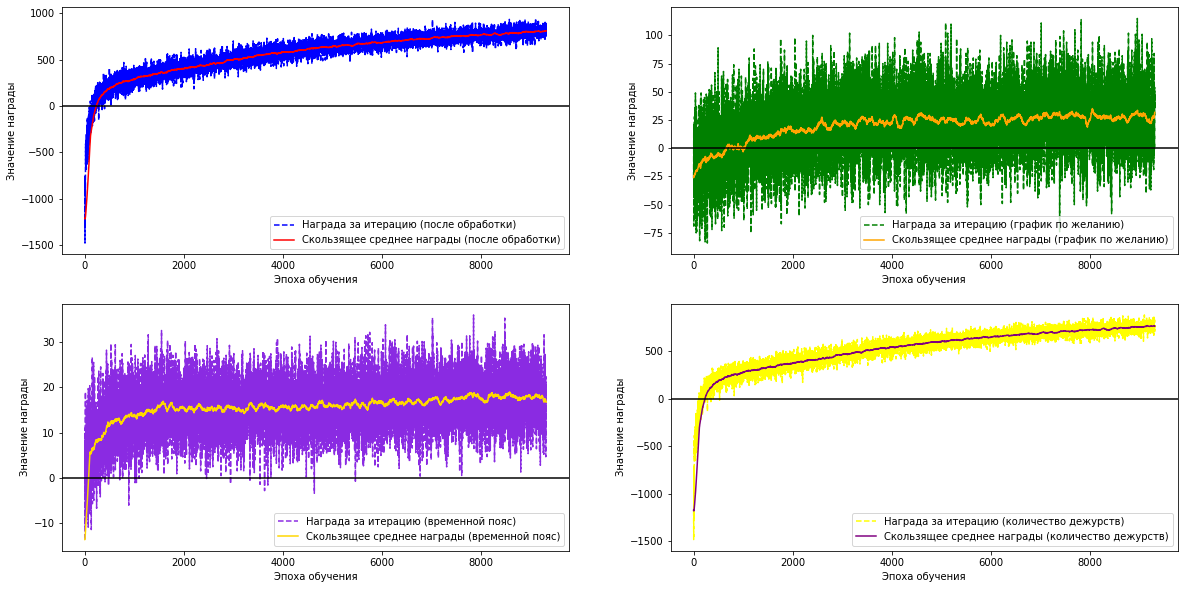

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
algorithm = REINFORCE(load_pretrained = False)  #Создаем объект алгоритма и среды
algorithm.train_algorithm(train_times = 10000)  #Обучаем алгоритм

По графикам видно, что модель обучается выбирать нужный результат, но обучается очень медленно и всё равно не идеально. Это вполне ожидаемо, по скольку базовый алгоритм REINFORCE не совершенный, и обычно находит локальные минимумы вместо глобальных. 

На практике, для подобных задач очень часто используется алгоритм q-learning, однако хорошие результаты также дают более продвинутые политические алгоритмы Примущественный Актер-Критик (Advantage Actor-Critic) и Ближайщая Оптимизация Политики (Рroximal Рolicy Щptimization), которые будут рассматриваться позже.

##Проверка работы модели

На завершение, применим обученную модель в инференсе. Для этого нужно установить тестовый режим train_mode = True, чтобы вместо предсказания вероятностей модель на прямую выбирала нужное действие.

In [ ]:
algorithm = REINFORCE(load_pretrained = True)  #Создаем объект алгоритма и среды
algorithm.environment.create_schedule(train_mode = True, episodes_in_batch = 1) #Создаем расписание
print(algorithm.environment.duty_timetable) #Выводим результат